DIVA

In [7]:
%matplotlib inline
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from exploration.data.data import load_sim_h5_v2 as load_sim_h5
from exploration.data.PlotTools import *
from exploration.algorithm.utils.logging import read_config_log

def create_dict(groups_k):
    return {k[0] + '_' + k[1]: [] for k in groups_k}

def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,c,sz):
    plt.sca(ax)
    plt.hold(True)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = c)

In [43]:
type_ops = ['proprio', 'simple']
mode_ops = ['autonomous','autonomous_pain']

groups_k = list(itertools.product(type_ops, mode_ops)) 

means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)

means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)

coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)

coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)

inter = create_dict(groups_k)
inter_av = create_dict(groups_k)

error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

std_ev = create_dict(groups_k)

comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)

for directory in ['diva_experiment_thesis_chap_5/', 'diva_experiment_thesis_chap_5_non_painful/']:

    data_files = os.listdir(directory)
    n_exp = 101000
    # Group by:


    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)

        whole_data, foo = load_sim_h5(data_file)
        interaction_data = whole_data.social.data.as_matrix(columns=None)
        interactions = np.zeros((interaction_data.shape[0],))
        interactions[~np.isnan(interaction_data[:, 0])] = 1


        social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', '_German_Vowels_sensor_eva_valset.h5'))

        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)

        s_con_v = social_data.somato.data.as_matrix()

        w_error_ = np.linalg.norm(whole_data.sensor_goal.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        w_con_v = whole_data.cons.data.as_matrix()

        w_comp_w = whole_data.competence.data.as_matrix()

        eva_errors = []
        with open(data_file.replace('sim_data.h5', '_German_Vowels_eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n','')
                eva_errors_str = line.split(': ')
                eva_errors += [float(eva_errors_str[1])]
                
        key = conf['type'] + '_' + conf['mode']
        if 'pain' in directory:
            key =  key + '_pain'
        
        
        means_s[key] += [np.mean(s_error_)]
        means_w[key] += [np.mean(w_error_)]

        coll_s[key] += [s_con_v[:n_exp]]
        coll_w[key] += [w_con_v[:n_exp]]

        inter[key] += [interactions[:n_exp]]

        error_ev[key] += [eva_errors]

        comp_w[key] += [w_error_[:n_exp]]

max_std=0
for i, k in enumerate(groups_k):
    group = k[0] + '_' + k[1]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))

    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)

    inter_av[group] = np.mean(np.array(inter[group]), axis=0)

    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)

    error_ev_av[group]= np.mean(np.array(error_ev[group]),axis=0)
    std_ev[group] = np.std(np.array(error_ev[group]),axis=0)
    max_std = max(max_std,max(std_ev[group].flatten()))
print(max_std)

0.286845740732726


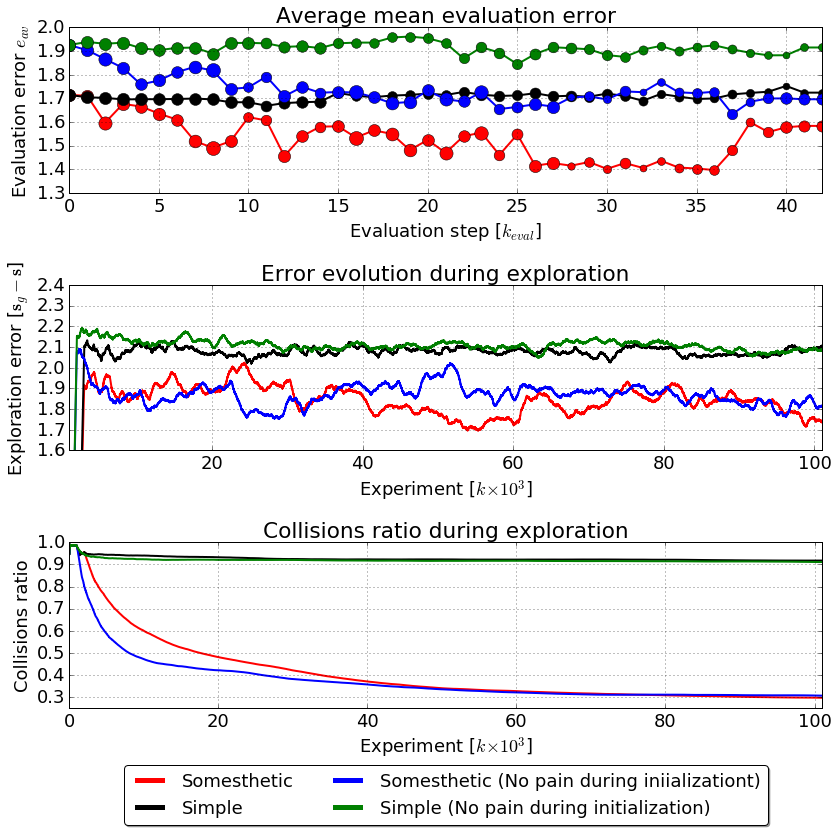

In [58]:
matplotlib.rcParams['figure.figsize'] = (12.0, 11)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'lines.linewidth': 2})

fig1, ax1 = plt.subplots(3,1)

plt.sca(ax1[0])
ax1[0].set_title('Average mean evaluation error')
plt.plot(error_ev_av['proprio_autonomous'], linestyle='-', marker='', color='r')
ms1 = [(x/max_std)*13 + 1 for x in std_ev['proprio_autonomous']]
plt.plot(error_ev_av['simple_autonomous'], linestyle='-', marker='', color='k')
ms2 = [(x/max_std)*13 + 1 for x in std_ev['simple_autonomous']]
plt.plot(error_ev_av['proprio_autonomous_pain'], linestyle='-', marker='', color='b')
ms3 = [(x/max_std)*13 + 1 for x in std_ev['proprio_autonomous']]
plt.plot(error_ev_av['simple_autonomous_pain'], linestyle='-', marker='', color='g')
ms4 = [(x/max_std)*13 + 1 for x in std_ev['simple_autonomous']]
std_markers(ax1[0],error_ev_av['proprio_autonomous'],'o','r',ms1)
std_markers(ax1[0],error_ev_av['simple_autonomous'],'o','k',ms2)
std_markers(ax1[0],error_ev_av['proprio_autonomous_pain'],'o','b',ms3)
std_markers(ax1[0],error_ev_av['simple_autonomous_pain'],'o','g',ms4)
plt.xlabel('Evaluation step [$k_{eval}$]')
plt.ylabel('Evaluation error $e_{av}$')
# ax1[0].set_ylim([1.3,1.8])
ax1[0].set_xlim([0,42])


x = np.linspace(0, len(incremental_mean(coll_av_w['proprio_autonomous'])), \
                len(incremental_mean(coll_av_w['proprio_autonomous'])))
scale_x = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
plt.sca(ax1[1])
ax1[1].set_title('Error evolution during exploration')
plt.hold(True)
plt.plot(moving_av(comp_av_w['proprio_autonomous'],1000), linestyle='-', marker='', color='r')
plt.plot(moving_av(comp_av_w['simple_autonomous'],1000), linestyle='-', marker='', color='k')
plt.plot(moving_av(comp_av_w['proprio_autonomous_pain'],1000), linestyle='-', marker='', color='b')
plt.plot(moving_av(comp_av_w['simple_autonomous_pain'],1000), linestyle='-', marker='', color='g')
ax1[1].set_xlabel('Experiment [$k$' + r'$\times$' + '$10^3$]')
plt.ylabel(r'Exploration error [$\mathbf{s}_g-\mathbf{s}$]')
ax1[1].set_xlim([1000,n_exp])
ax1[1].set_ylim([1.6,2.4])
ax1[1].xaxis.set_major_formatter(ticks_x)

plt.sca(ax1[2])
ax1[2].set_title('Collisions ratio during exploration')
plt.hold(True)
plt.plot(x,incremental_mean(coll_av_w['proprio_autonomous']), linestyle='-', marker='', color='r')
plt.plot(x,incremental_mean(coll_av_w['simple_autonomous']), linestyle='-', marker='', color='k')
plt.plot(x,incremental_mean(coll_av_w['proprio_autonomous_pain']), linestyle='-', marker='', color='b')
plt.plot(x,incremental_mean(coll_av_w['simple_autonomous_pain']), linestyle='-', marker='', color='g')
ax1[2].set_xlabel('Experiment [$k$' + r'$\times$' + '$10^3$]')
ax1[2].set_ylabel('Collisions ratio')
ax1[2].set_xlim([0,n_exp])
ax1[2].set_ylim([0.25,1])
ax1[2].xaxis.set_major_formatter(ticks_x)
lgd = plt.legend(['Somesthetic', 'Simple','Somesthetic (No pain during iniializationt)', \
                  'Simple (No pain during initialization)'],\
            ncol=2,loc='lower right',fontsize=18, bbox_to_anchor=(0.94, -.76),
          fancybox=True, shadow=True)

for legobj in lgd.legendHandles:
    legobj.set_linewidth(5.0)
for ax in ax1:
    ax.grid(True)
plt.tight_layout()

In [59]:
fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter5/images/vt_results_evo.eps',
             format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')
#fig1.savefig(directory + 'vt_results.eps',\
#            format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')

In [18]:
conf['type']

'proprio'

In [41]:
std_ev

{'proprio_autonomous': nan,
 'proprio_autonomous_pain': array([0.20929143, 0.15935216, 0.16376245, 0.17928018, 0.16492863,
        0.1822157 , 0.188477  , 0.21817367, 0.17401889, 0.16334367,
        0.18333441, 0.1333128 , 0.14867356, 0.16539235, 0.172356  ,
        0.16865332, 0.13349846, 0.14225204, 0.16999838, 0.14707064,
        0.18015238, 0.19771877, 0.17624794, 0.110147  , 0.16716633,
        0.20892338, 0.16339157, 0.17246372, 0.1484105 , 0.14867794,
        0.19061656, 0.1840058 , 0.17850319, 0.13401248, 0.13239588,
        0.11988056, 0.0756384 , 0.20275043, 0.13305975, 0.20233284,
        0.21726795, 0.22964258, 0.22964258]),
 'simple_autonomous': nan,
 'simple_autonomous_pain': array([0.20929143, 0.26360556, 0.26990408, 0.25179739, 0.24932765,
        0.24449202, 0.22687589, 0.2274264 , 0.26816188, 0.19840285,
        0.21678889, 0.20414725, 0.19500914, 0.21283327, 0.20263425,
        0.18517078, 0.17700391, 0.18903498, 0.16849593, 0.16819353,
        0.18533899, 0.18935039